In [25]:
from pathlib import Path
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

In [26]:
path = Path(os.getcwd()).parent

gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')
gbs = gbs.fillna(gbs.median())
gesis = gesis.fillna(gesis.median())

gbs['Umfrage'] = 1
gesis['Umfrage'] = 0

gesis.drop(columns = ['GESIS-CODE'], axis=1, inplace = True)
gbs.drop(columns = ['GBS-CODE', 'Gruppe'], axis=1, inplace = True)
drop = ['Personen im Haushalt', 'Druck', 'Optimismus Zukunft', 'Geburtsland', 'Nationalitaet',
       'Familienstand', 'Berufsgruppe', 'Leben genießen', 'Zu Nichts aufraffen',
       'Alles anstrengend', 'Zufriedenheit Leben', 'Aktiv', 'Verärgert', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'Nettoeinkommen Selbst', 'Nettoeinkommen Haushalt', 'Schlechter Schlaf',
       'Wahlabsicht', 'Desinteresse Politiker']

gbs.drop(columns=drop, axis=1, inplace=True)
gesis.drop(columns=drop, axis=1, inplace=True)

df = pd.concat([gesis, gbs])
df.to_csv(os.path.join(path, 'data/gbs_and_gesis.csv'), encoding = "ISO-8859-1", index= False)
#df1 = pd.concat([gesis.head(2124), gbs.head(289)])

best params: LogisticRegression(C=0.50001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=450,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 0.50001}
best score: 0.6988400994200498


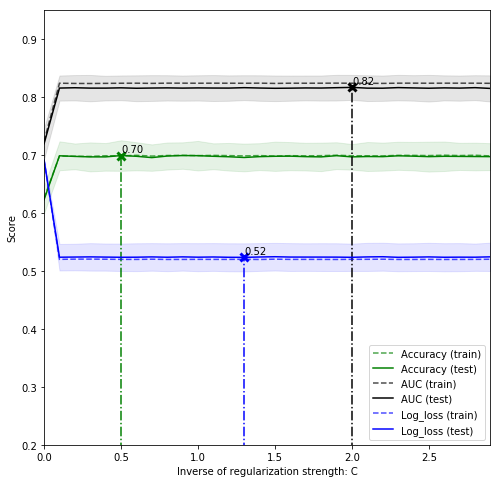

In [27]:
#grid search code from: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

y = df.Umfrage
X = df.drop(columns=['Umfrage'], axis=1).copy()

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=450), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')
gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(8, 8))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.2, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.savefig(os.path.join(path, 'tex/fig/logistic_grid.png'))
plt.show()

best params: SVC(C=1e-05, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
best params: {'C': 1e-05}
best score: 0.8800745650372825


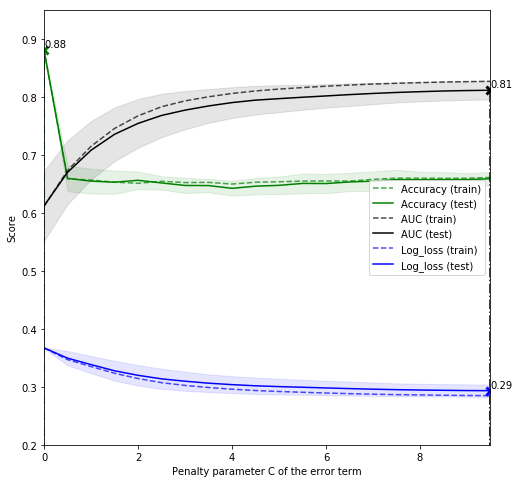

In [29]:
#grid search code from: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

from sklearn import svm

y = df.Umfrage
X = df.drop(columns=['Umfrage'], axis=1).copy()

param_grid = {'C': np.arange(1e-05, 10, 0.5)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', probability=True), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')
gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(8, 8))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Penalty parameter C of the error term")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.2, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.savefig(os.path.join(path, 'tex/fig/svm_grid.png'))
plt.show()